# Assingment 5.1
### Leonard Littleton and Andrew Zazueta

### Libraries

In [3]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.inspection import permutation_importanc

### Reading cleaned data

In [4]:
df_modeling = pd.read_csv('capstone_df_cleaned.csv')

### Splitting Data into Training, Validation, and Testing Data Sets

Since our data is imbalanced with X% of the data being churned participants, we will need to resmaple our trianing set before we can build our models

In [5]:
# Our X will be all columns excluding the response feature and participant identification feature
X = df_modeling.drop(['Certification Flag', 'Participant Key'], axis = 1)
y = df_modeling['Certification Flag']

# Splitting data into a training set, validation set, and testing set with.
# The 'stratify' argument ensures that an equal % of chruned/unchurned go into each data set.
train_X, rem_X, train_y, rem_y = train_test_split(X, y, train_size=0.7, random_state=42, stratify = y)
valid_X, test_X, valid_y, test_y = train_test_split(rem_X, rem_y, train_size=0.5, random_state=42, stratify = rem_y)

### Resampling imbalanced data

In [6]:
# Distribution of y in data sets to ensure the % is equal

print(train_y.value_counts()[0]/len(train_y))
print(valid_y.value_counts()[0]/len(valid_y))
print(test_y.value_counts()[0]/len(test_y))

0.9147781023351534
0.9147747625640181
0.9147747625640181


In [6]:
#### Resampling stratgey: SMOTE (Synthetic Minority Oversampling Technique) with Random Undersampling

# creating pipeline
over = SMOTE(sampling_strategy=0.1, random_state = 42)
# sampling_strategy = 1 means both classes will be exactly balanced
under = RandomUnderSampler(sampling_strategy=1, random_state = 42) 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps = steps)

# resampling data set
train_X, train_y = pipeline.fit_resample(train_X, train_y)

In [7]:
# seeing new distribution of y

print(train_y.value_counts())

1    44094
0    44094
Name: Certification Flag, dtype: int64


### Modeling

#### Baseline Models

##### Naive Bayes

In [27]:
nb = GaussianNB()
nb.fit(train_X, train_y)
y_pred_valid = nb.predict(valid_X)
print('Accuracy Score - ', accuracy_score(valid_y, y_pred_valid))
print(classification_report(valid_y, y_pred_valid))

Accuracy Score -  0.6133641846821117
              precision    recall  f1-score   support

           0       0.99      0.58      0.73     94488
           1       0.18      0.96      0.30      8803

    accuracy                           0.61    103291
   macro avg       0.58      0.77      0.52    103291
weighted avg       0.92      0.61      0.70    103291



This model gives us a good idea for the minium accuracy we want to beat for the following models. Naive Bayes produced a 61% accuracy in predicting churned participants, which is much lower than the baseline accuracy of 91% (the accuracy of a model that only predicts 'churned').

#### Other Models

##### Logistic Regression

In [10]:
lr = LogisticRegression(random_state=42, max_iter=500)
lr.fit(train_X, train_y)
y_pred_valid = lr.predict(valid_X)
print('Accuracy Score - ', accuracy_score(valid_y, y_pred_valid))
print(classification_report(valid_y, y_pred_valid))

Accuracy Score -  0.8867471512522872
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     94488
           1       0.43      0.96      0.59      8803

    accuracy                           0.89    103291
   macro avg       0.71      0.92      0.76    103291
weighted avg       0.95      0.89      0.91    103291



Logistic regression looks to be a great model.  Let's take a look at other models and determine which performs best stock.

##### Neural Network

In [15]:
nn = MLPClassifier(random_state=42, max_iter=500)
nn.fit(train_X, train_y)
y_pred_valid = nn.predict(valid_X)
print('Accuracy Score - ', accuracy_score(valid_y, y_pred_valid))
print(classification_report(valid_y, y_pred_valid))

Accuracy Score -  0.8890125954826654
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     94488
           1       0.43      0.96      0.60      8803

    accuracy                           0.89    103291
   macro avg       0.71      0.92      0.77    103291
weighted avg       0.95      0.89      0.91    103291



Neural Networks also seem to output a great accuracy.

##### Random Forest

In [12]:
rf = RandomForestClassifier(random_state=42)
rf.fit(train_X, train_y)
y_pred_valid = rf.predict(valid_X)
print('Accuracy Score - ', accuracy_score(valid_y, y_pred_valid))
print(classification_report(valid_y, y_pred_valid))

Accuracy Score -  0.9236816373159327
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     94488
           1       0.53      0.97      0.68      8803

    accuracy                           0.92    103291
   macro avg       0.76      0.95      0.82    103291
weighted avg       0.96      0.92      0.93    103291



Random Forests have the highest accuracy of any model thus far, so we will explore it deeper.

The following code was created here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [18]:
#Take a look at the default parameters for Random Forest
from pprint import pprint

pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


The best approach is to consider a subset of the parameters.  The sklearn documentation tell us that number of trees and number of features are two of the most importnat.  So we will tune those and some others.

In [23]:
#Number of trees
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

#Number of features
max_features = ['auto', 'sqrt', 'log2']

#Number of tree levels
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

#Min number of samples to split
min_samples_split = [2, 5, 10]

#Min number of samples at leaf
min_samples_leaf = [1, 2, 4]

#Criterion
criterion = ['gini', 'entropy', 'log_loss']

#Bootstrap method
bootstrap = [True, False]

#Out of bag
oob_score = [True, False]

In [24]:
#Create a random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'criterion': criterion,
              'bootstrap': bootstrap, 'oob_score': oob_score}

pprint(random_grid)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy', 'log_loss'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'oob_score': [True, False]}


In [25]:
#Random Search Training
rf_rs = RandomForestClassifier()

#100 combinations, 5-fold cross validation
rf_random = RandomizedSearchCV(estimator=rf_rs, param_distributions=random_grid, n_iter=100, cv=5, verbose=2, random_state=42,
                              n_jobs=-1)

rf_random.fit(train_X, train_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Leonard\miniconda3\envs\ADS500B\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.91816352        nan 0.91793673 0.91835629        nan
        nan        nan        nan 0.92229106 0.91951291 0.92181481
 0.91944488        nan        nan 0.91792539 0.92982043 0.91956961
        nan        nan        nan        nan 0.92277865 0.91795941
        nan        nan 0.92186017 0.93655604 0.93584164 0.92320955
 0.91828825 0.91946755        nan        nan 0.91949023 0.93949293
 0.91837897 0.91831093 0.93405002 0.91970568 0.91953559 0.92826693
        nan        nan        nan 0.92102106 0.91798209 0.91826557
 0.91952425 0.91803879 0.91795941 0.91835629        nan 0.91798209
 0.91792539 0.92183749 0.91792539        nan 0.92099838        nan
        nan 0.94007125 0.91848102 0.92073756 0.91819754 0.918447
        nan 0.94055883        nan 0.91984175        nan 0.92205294
 0.94053616 0.91836763 0.94195357 0.918

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                 

In [26]:
#determine the best parameters
rf_random.best_params_

{'oob_score': False,
 'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'criterion': 'gini',
 'bootstrap': False}

In [8]:
#rerun the random forest model using the new parameters
rf = RandomForestClassifier(oob_score=False, n_estimators=400, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=40, criterion='gini', bootstrap=False, random_state=42)
rf.fit(train_X, train_y)
y_pred_valid = rf.predict(valid_X)
print('Accuracy Score - ', accuracy_score(valid_y, y_pred_valid))
print(classification_report(valid_y, y_pred_valid))

Accuracy Score -  0.9290935318662807
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     94488
           1       0.55      0.97      0.70      8803

    accuracy                           0.93    103291
   macro avg       0.77      0.95      0.83    103291
weighted avg       0.96      0.93      0.94    103291



In [40]:
#determine the % improvement
print((0.9290935318662807 - 0.9236816373159327) / 0.9236816373159327 * 100, '% improvement')

0.585904745933258 % improvement


A half percent improvement isn't great, but it is an improvment.  We can try to do even better with a grid search.

In [41]:
#Create a grid search based on the results of the random search
cv_grid = {
    'n_estimators': [300,400,500], 
    'max_features': ['sqrt'], 
    'max_depth': [30,40,50], 
    'min_samples_split': [1,2,3], 
    'min_samples_leaf': [0,1,2], 
    'criterion': ['gini'],
    'bootstrap': [False], 
    'oob_score': [False]
}

rf_gs = RandomForestClassifier()

In [42]:
#kick off the grid search model
grid_search = GridSearchCV(estimator=rf_gs, param_grid=cv_grid, cv=5, n_jobs=-1, verbose=2)

In [43]:
#fit the grid search
grid_search.fit(train_X, train_y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\Leonard\miniconda3\envs\ADS500B\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.94000321 0.9397424  0.9401166  0.93924347 0.93915275 0.9388806
        nan        nan        nan 0.92680414 0.92674744 0.9267928
 0.92694021 0.92686083 0.92680414        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.94252055 0.94225975 0.94244118
 0.94173813 0.94165876 0.94195358        nan        nan        nan
 0.92929881 0.92890194 0.92940087 0.9290947  0.92923077 0.92902667
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.94208966 0.94233912 0.94225975 0.94176081 0.94168143 0.94171545
        nan        nan        nan 0.929

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [30, 40, 50], 'max_features': ['sqrt'],
                         'min_samples_leaf': [0, 1, 2],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [300, 400, 500],
                         'oob_score': [False]},
             verbose=2)

In [44]:
#display the best params
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'oob_score': False}

In [2]:
#rerun the random forest model using the new parameters
rf = RandomForestClassifier(oob_score=False, n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=40, criterion='gini', bootstrap=False, random_state=42)
rf.fit(train_X, train_y)
y_pred_valid = rf.predict(valid_X)
print('Accuracy Score - ', accuracy_score(valid_y, y_pred_valid))
print(classification_report(valid_y, y_pred_valid))

NameError: name 'RandomForestClassifier' is not defined

In [46]:
#determine the % improvement
print((0.9289192669254823 - 0.9236816373159327) / 0.9236816373159327 * 100, '% improvement')

0.5670384034881701 % improvement


The grid search proved to not be better than our random result.  So the parameters we tuned with the random search will be deemed our best model.

Let's look at what features the random forest deems as most important

In [51]:
#variable importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

                                         feature    importance       std
6                                  Clinic Status  2.387410e-07  0.000002
38  Proof Of ID_DO NOT USE!!!Immunization Record  1.192653e-06  0.000008
19           Child Health Insurance Program Flag  4.342774e-06  0.000041
53                Proof Of ID_TANF Benefit Proof  1.560311e-05  0.000018
47             Proof Of ID_No Source of Identity  2.156165e-05  0.000019
..                                           ...           ...       ...
58                            TV/Video Viewing_3  4.343031e-02  0.062766
8                               Household Income  4.416244e-02  0.002041
84                   Participant Status_Inactive  7.491811e-02  0.109314
4                               Terminated Count  2.577058e-01  0.242152
5                             Disqualified Count  2.688113e-01  0.254816

[88 rows x 3 columns]


##### XGBoost

The following function and code is created by Aatshay Jain and has been modified to fit our needs. In this section, we see an optimal way for tuning the XGBoost hyper parameters. Link here: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [23]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    target = 'Certification Flag'
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds) #, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
                    
    # graphing feature importance
    features = predictors
    importances = alg.feature_importances_
    indices = np.argsort(importances)
    num_features = 20
    plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
    plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
    plt.xlabel('Relative Importance')
    plt.show()

We will first try to find the 20 most important features based on the parameters below. This is to save time for the later hypertuning we will be conducting. Tuning all ~90 features takes upwards of 30min for each grid search, so the reduced data set will help with this.

C:\Users\mzazu\miniconda3\envs\ADS500B\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,



Model Report
Accuracy : 0.9201
AUC Score (Train): 0.956400


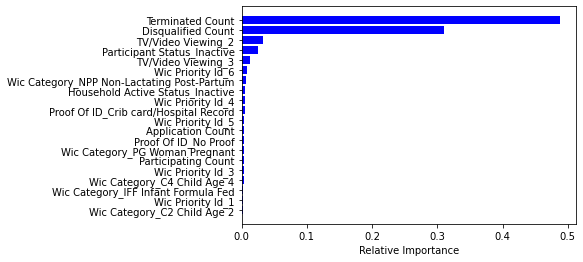

In [37]:
train_X_y = pd.concat([train_X, train_y], axis = 1)
predictors = [x for x in train_X.columns]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)
modelfit(xgb1, train_X_y, predictors)

Before we start tuning, lets see the validation set accuracy.

In [46]:
xgb1.fit(train_X, train_y)
y_pred_valid = xgb1.predict(valid_X)
print('Accuracy Score - ', accuracy_score(valid_y, y_pred_valid))
print(classification_report(valid_y, y_pred_valid))

Accuracy Score -  0.8809964082059424
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     94488
           1       0.41      0.96      0.58      8803

    accuracy                           0.88    103291
   macro avg       0.71      0.92      0.75    103291
weighted avg       0.95      0.88      0.90    103291



The XGBoost accuracy of 0.88 is much better than Naive Bayes at 0.61, but lets see what we can improve it to.

Now that we see the most important features for our XGBoost model, lets start tuning the hyperparameters. We will use these 20 features for our XGBoost modeling building, but we will use every feature for our final model. 

In [53]:
cols = ['Terminated Count', 'Disqualified Count', 'TV/Video Viewing_2', 'TV/Video Viewing_3', 'Participant Status_Inactive',
       'Wic Category_NPP Non-Lactating Post-Partum', 'Proof Of ID_No Proof', 'Wic Priority Id_6',
        'Wic Category_PG Woman Pregnant', 'Household Active Status_Inactive', 'Wic Priority Id_4', 'Application Count',
       'Participating Count', 'Wic Category_C4 Child Age 4', 'Wic Priority Id_3', 'Proof Of ID_Crib card/Hospital Record',
       'Wic Priority Id_5', 'Wic Category_IFF Infant Formula Fed', 'Wic Priority Id_1', 'Wic Category_C2 Child Age 2']

train_X_boost = train_X[cols]

Tuning max_depth and min_child_weight.

In [39]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=20, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=42), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(train_X_boost,train_y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.77910666, 0.80392847, 0.73026228, 1.10640364, 1.09919748,
         1.09679389, 1.57342744, 1.54640255, 1.53759508, 2.03564687,
         1.99380875, 1.72496443]),
  'std_fit_time': array([0.02703287, 0.05136312, 0.01974152, 0.00845932, 0.02114171,
         0.00677144, 0.02109944, 0.02000804, 0.01067491, 0.02438138,
         0.01766841, 0.24382765]),
  'mean_score_time': array([0.02602372, 0.0212193 , 0.02081895, 0.02161922, 0.02202001,
         0.0228209 , 0.02302089, 0.02322083, 0.02242031, 0.02402158,
         0.02542319, 0.02222013]),
  'std_score_time': array([0.00275915, 0.00204132, 0.0027156 , 0.00215596, 0.00089527,
         0.00213726, 0.00063294, 0.00160151, 0.00206099, 0.00141532,
         0.00233426, 0.00381935]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

From this analysis, we can choose a max_depth of 9 and a min_child_weight of 1 as the best values for these parameters.

Now, lets tune gamma with our new max_depth and min_child_weight parameters.

In [43]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=20, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=42), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(train_X_boost,train_y)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([2.03384552, 2.04305472, 2.10350947, 2.21561093, 1.87950573]),
  'std_fit_time': array([0.01369451, 0.01413278, 0.01923775, 0.02457914, 0.59471875]),
  'mean_score_time': array([0.03162861, 0.02882614, 0.02822556, 0.02902656, 0.02262063]),
  'std_score_time': array([0.00512724, 0.00462582, 0.00349016, 0.00126591, 0.0052434 ]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.94356883, 0.94347526, 0.94351119, 0.94370722, 0.94363519]),
  'split1_test_score': array([0.94342013, 0.94343951, 0.94341421, 0.94337459, 0.9433806 ]),
  'split2_test_score': array([0.94209703, 0.94207905, 0.94205537, 0.94203533, 0.94201119]),
  'split3_test_score': array([0.94381734, 0.94380344, 0.94383352, 0.94383691, 0.9438535 ]),

A gamma of 0.4 was determined to be the best value.

For our final step, lets tune subsample and colsample_bytree.

In [44]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=20, max_depth=9,
 min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=42), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(train_X_boost,train_y)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([1.80884051, 1.68652987, 1.62187128, 1.59104352, 1.96198063,
         1.92714863, 1.8749011 , 1.80503764, 2.18218055, 2.21040554,
         2.19860058, 2.13153996, 2.44581904, 2.34092426, 2.28207054,
         2.13493676]),
  'std_fit_time': array([0.0629512 , 0.01870376, 0.0200644 , 0.01797827, 0.04154168,
         0.0515393 , 0.03969204, 0.03774134, 0.03208836, 0.05412894,
         0.09682345, 0.0317085 , 0.04614832, 0.03131052, 0.0348864 ,
         0.1103141 ]),
  'mean_score_time': array([0.03242955, 0.03343058, 0.02882614, 0.02802515, 0.02882619,
         0.02682409, 0.02582345, 0.02582369, 0.02322083, 0.02502322,
         0.02602444, 0.02482243, 0.02502289, 0.02642417, 0.02742481,
         0.02101917]),
  'std_score_time': array([0.00905472, 0.00602539, 0.00417024, 0.00548233, 0.00581598,
         0.00116705, 0.00074905, 0.00231667, 0.00256316, 0.00322811,
         0.00283156, 0.00194067, 0.00126644, 0.00355882, 0.00344412,
         0.00390191]),
  'param_c

Both 'colsample_bytree' and 'subsample' have an optimal value of 0.9.

Now, lets created a model with the newly tuned parameters.

In [51]:
xgb_final = XGBClassifier(
 learning_rate =0.1,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.9,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)
xgb_final.fit(train_X, train_y)
y_pred_valid = xgb_final.predict(valid_X)
print('Accuracy Score - ', accuracy_score(valid_y, y_pred_valid))
print(classification_report(valid_y, y_pred_valid))

Accuracy Score -  0.8890416396394653
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     94488
           1       0.43      0.97      0.60      8803

    accuracy                           0.89    103291
   macro avg       0.71      0.92      0.77    103291
weighted avg       0.95      0.89      0.91    103291



Our model tuning increased the accuracy from 0.88 to 0.89, which is marginal. However, there was an improvement. Lets see what the test set accuracy is.

In [66]:
y_pred_test = xgb_final.predict(test_X)
print('Accuracy Score - ', accuracy_score(test_y, y_pred_test))
print(classification_report(test_y, y_pred_test))

Accuracy Score -  0.890522891636251
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     94488
           1       0.44      0.97      0.60      8803

    accuracy                           0.89    103291
   macro avg       0.72      0.93      0.77    103291
weighted avg       0.95      0.89      0.91    103291



We get the same accuracy as our validation set. Now lets see the AUC. Note: The code used to build the ROC curve can be found here: https://stackoverflow.com/questions/33518129/r-xgboost-plot-roc-curve

In [10]:
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = roc_curve(test_y, y_pred_test)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.gcf().savefig('roc.png')

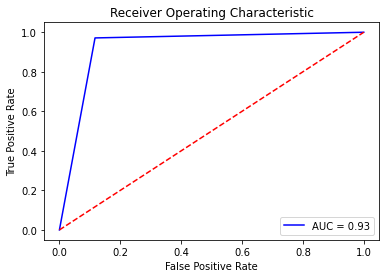

In [64]:
#XGBoost Best Model ROC Curve
buildROC(test_y, y_pred_test)

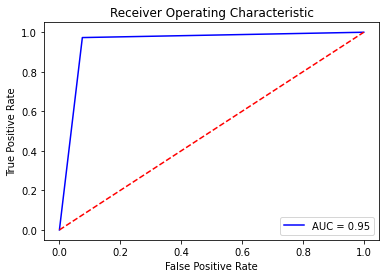

In [12]:
#Random Forest Best Model ROC Curve
y_pred_test = rf.predict(test_X)

buildROC(test_y, rf_y_pred_test)